I did not include xgboost, lightgbm in the requirements.txt, if you want use this notbook install them seperately from requirements.txt

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer
from imblearn.combine import SMOTETomek
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
diabete = pd.read_csv("diabetes.csv")
diabete.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [3]:
diabete.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
for col in diabete.columns:
    print("{}".format(diabete[col].dtype))

int64
int64
int64
int64
int64
float64
float64
int64
int64


In [5]:
diabete.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [6]:
diab=diabete.drop(["Outcome"], axis=1)
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,138,62,35,0,33.6,0.127,47
1,0,84,82,31,125,38.2,0.233,23
2,0,145,0,0,0,44.2,0.630,31
3,0,135,68,42,250,42.3,0.365,24
4,1,139,62,41,480,40.7,0.536,21


<AxesSubplot:>

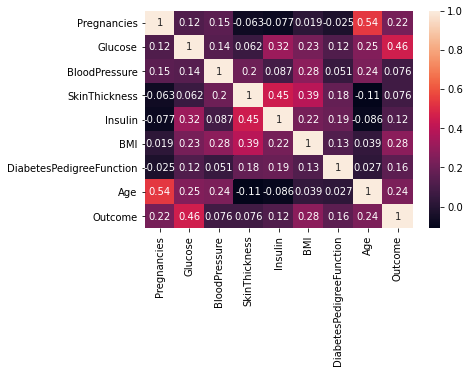

In [7]:
corr=diabete.corr()
sns.heatmap(corr, annot=True)

In [8]:
def diagnostic(data, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1,3,1)
    sns.distplot(data[variable])
    plt.subplot(1,3,2)
    stats.probplot(data[variable], dist="norm", plot=plt)
    plt.subplot(1,3,3)
    sns.boxplot(data[variable])

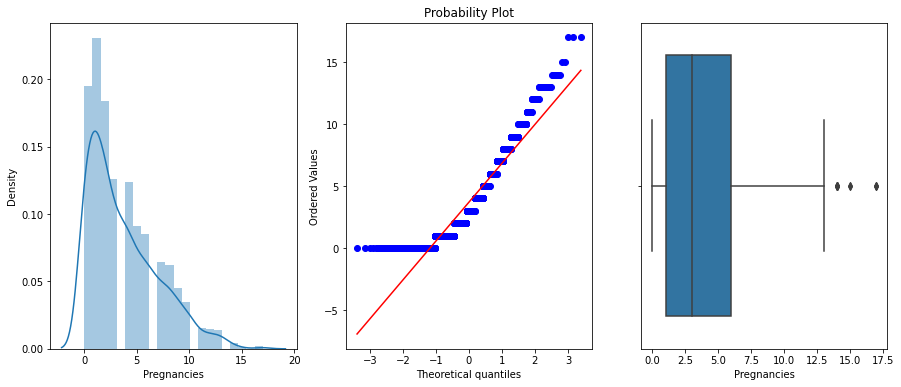

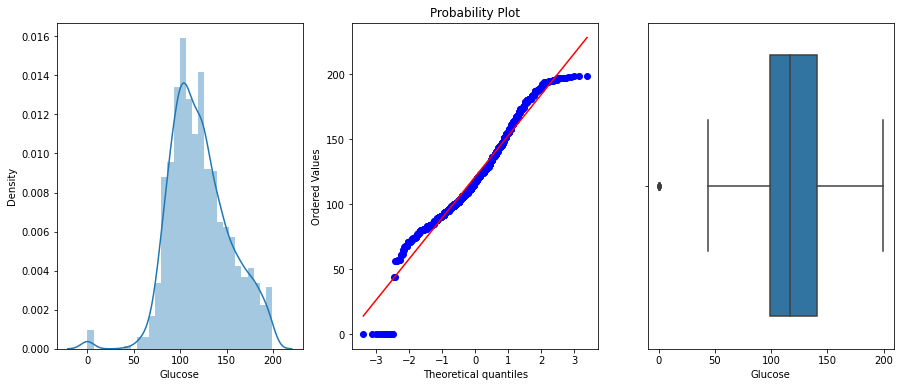

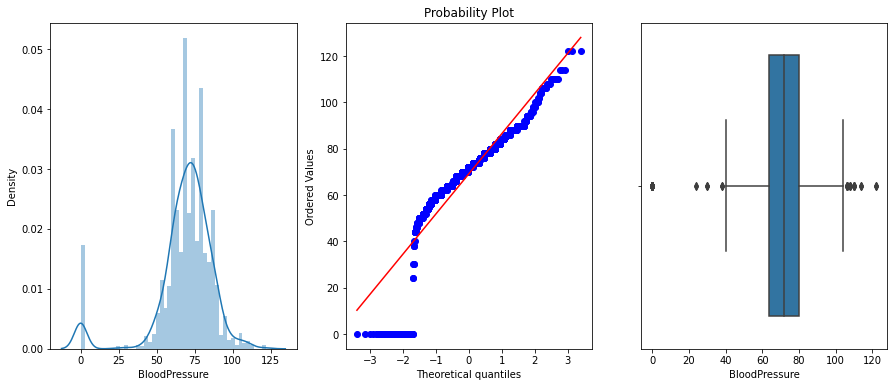

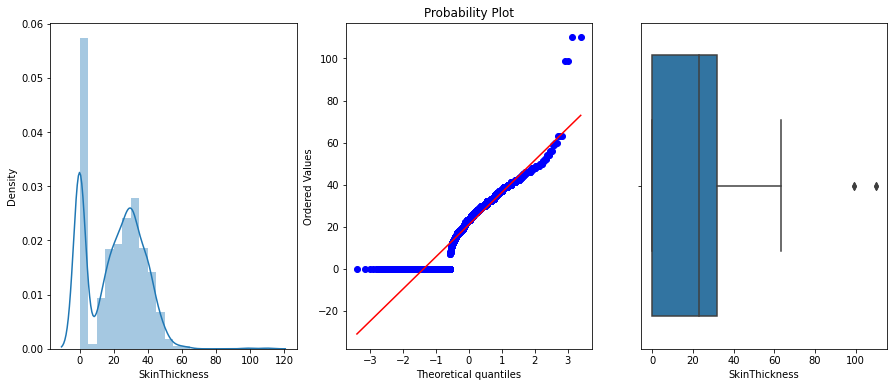

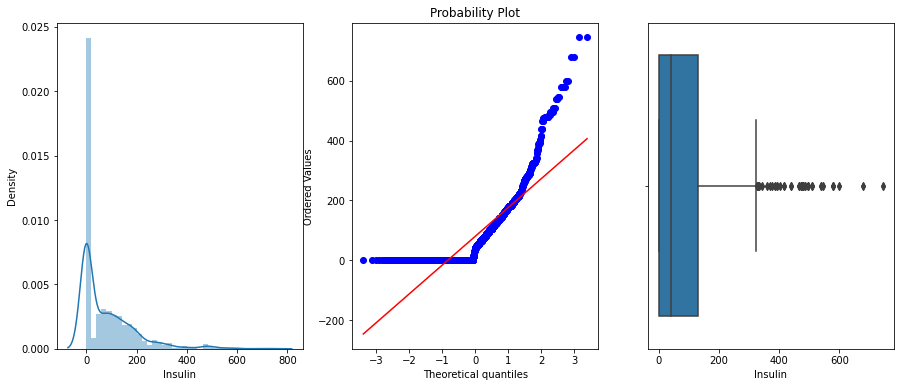

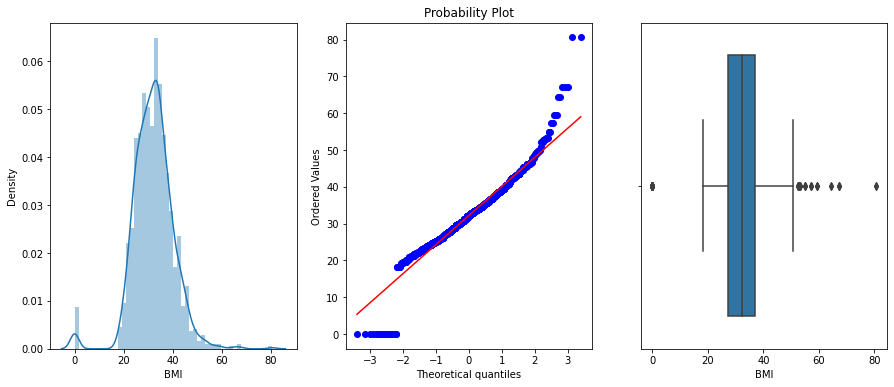

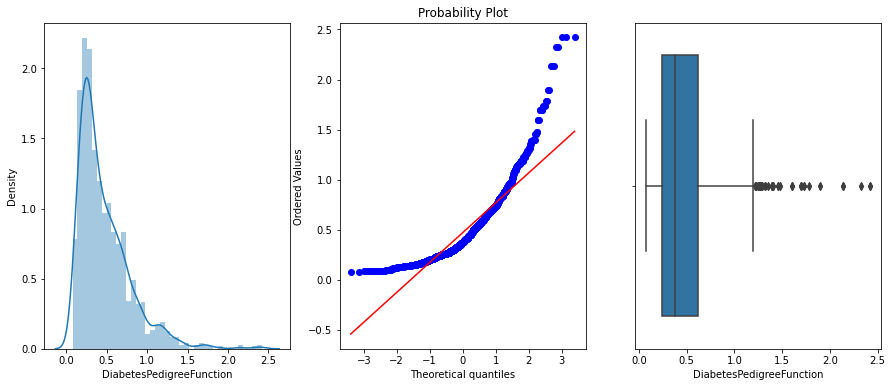

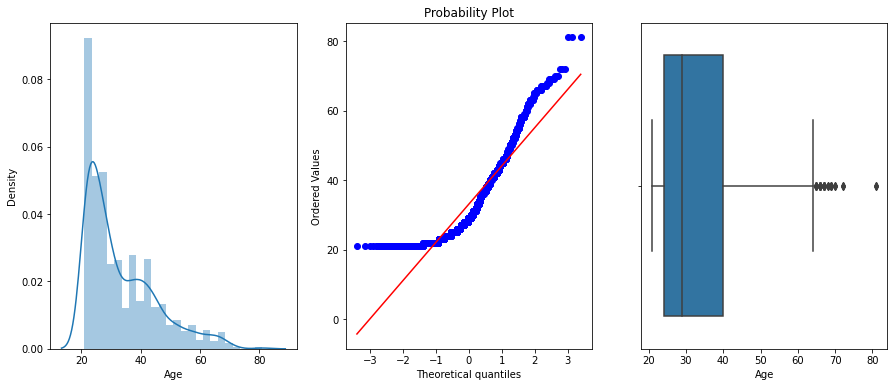

In [9]:
for colum in diab.columns:
    diagnostic(diab, colum)

All the variable have outliers

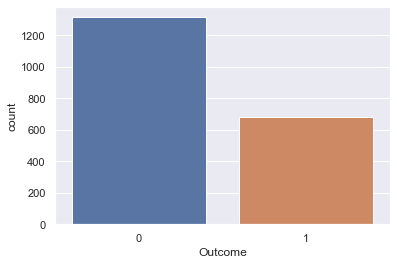

In [10]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Outcome", data=diabete)

The Data set is imbalanced. Let us go and handle it

In [11]:
X = diab
y = diabete["Outcome"]
oversampling = SMOTETomek(random_state=42)
X_res, y_res = oversampling.fit_resample(X,y)

In [12]:
data = pd.concat([X_res, y_res], axis=1)

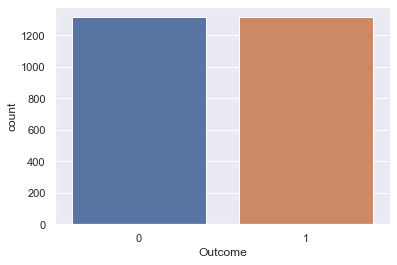

In [13]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Outcome", data=data)

Let us handle the outliers by Capping-IQR-proximity-rule

In [14]:
x_train,x_test,y_train,y_test = train_test_split(data.drop(["Outcome"], axis=1), data["Outcome"],
                                                 test_size=0.2, random_state=0, stratify=data["Outcome"])

In [15]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [16]:
def handle_outliers(xtrain,xtest,column):
    for col in column:
        CU_upper_limit, CU_lower_limit = find_skewed_boundaries(xtrain,col, 1.5)
        xtrain[col+"1"]= np.where(xtrain[col] > CU_upper_limit, CU_upper_limit,
                       np.where(xtrain[col] < CU_lower_limit, CU_lower_limit, xtrain[col]))

        xtest[col+"1"]= np.where(xtest[col] > CU_upper_limit, CU_upper_limit,
                       np.where(xtest[col] < CU_lower_limit, CU_lower_limit, xtest[col]))
    return xtrain,xtest
        

In [17]:
x_traino,x_testo = handle_outliers(x_train,x_test,diab.columns)
x_trainf = x_traino.drop(diab.columns, axis=1)
x_testf = x_testo.drop(diab.columns, axis=1)

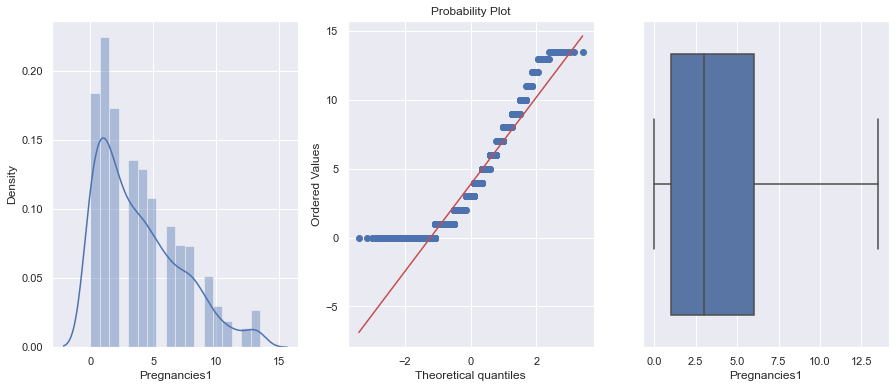

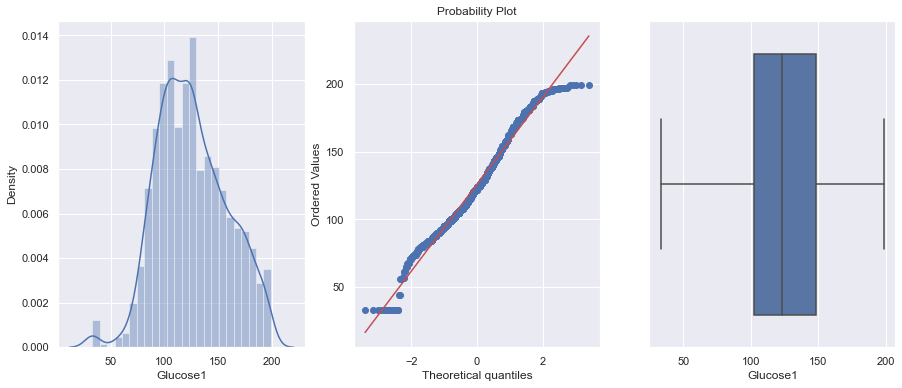

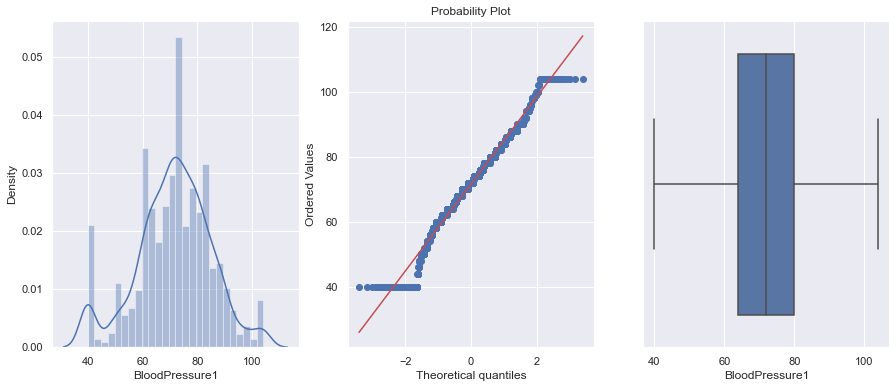

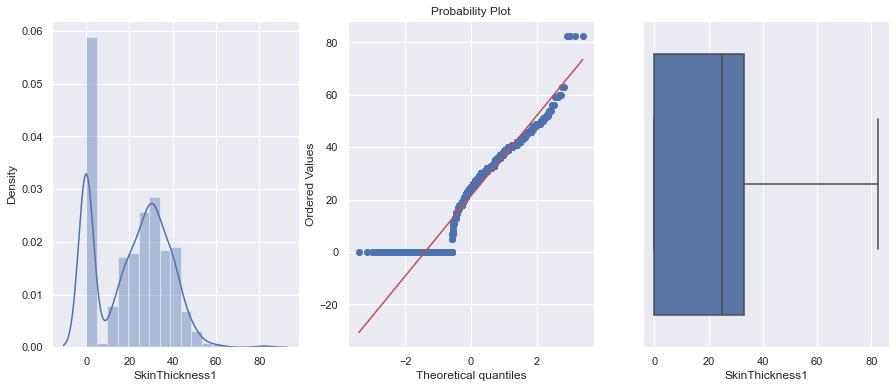

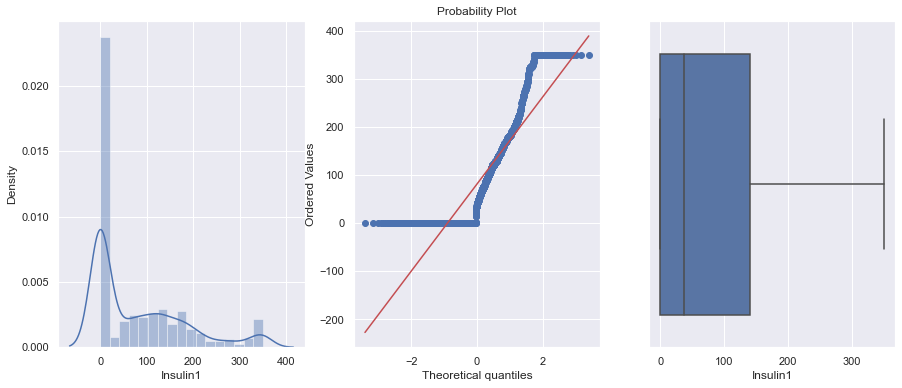

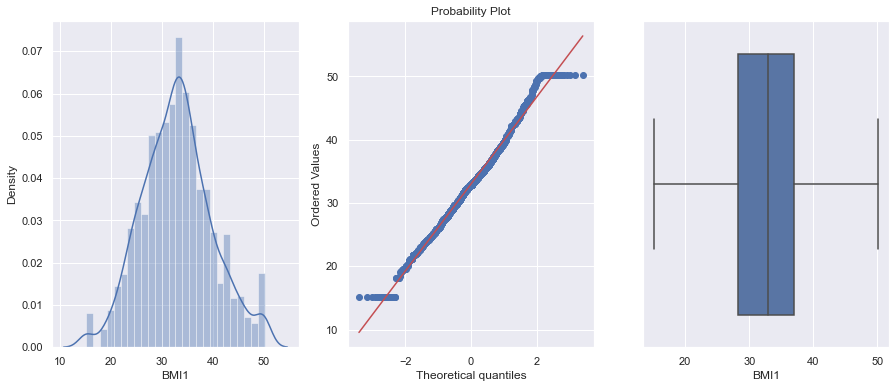

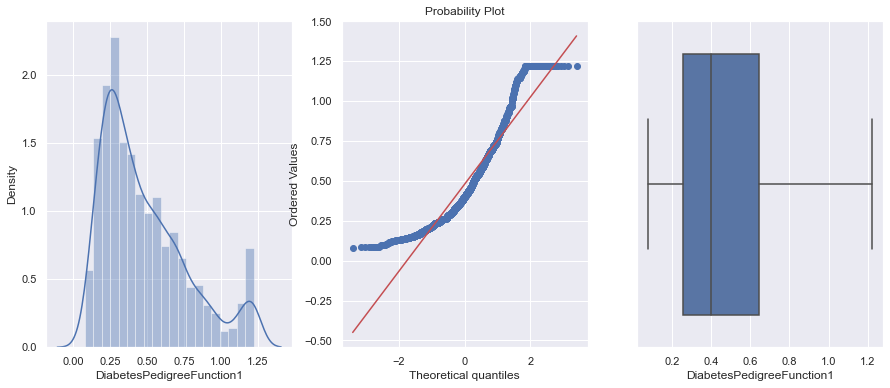

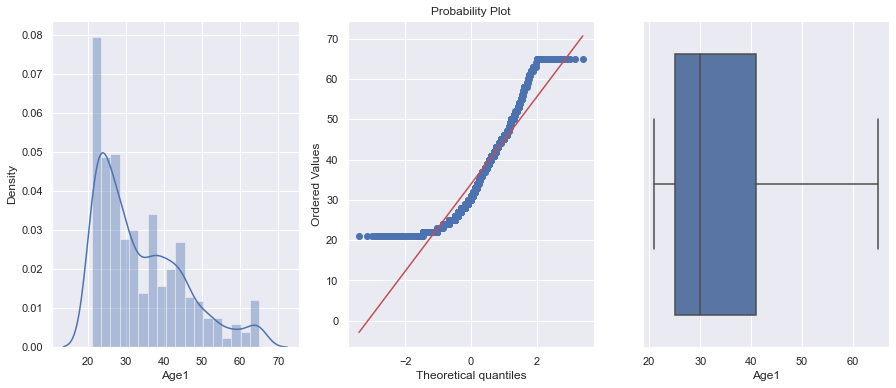

In [18]:
for colum in x_trainf.columns:
    diagnostic(x_trainf, colum)

In [20]:
dic_col = {'Pregnancies1':'Pregnancies', 'Glucose1':'Glucose', 'BloodPressure1':'BloodPressure', 'SkinThickness1':'SkinThickness',
          'Insulin1':'Insulin', 'BMI1':'BMI', 'DiabetesPedigreeFunction1':'DiabetesPedigreeFunction', 'Age1':'Age'}

In [21]:
x_trainf.rename(columns=dic_col, inplace=True)

In [22]:
x_testf.rename(columns=dic_col, inplace=True)

In [24]:
scale = RobustScaler()
coltrain = x_trainf.columns
coltest = x_testf.columns
x_trainf = scale.fit_transform(x_trainf)
x_trainf = pd.DataFrame(x_trainf,columns=coltrain)

x_testf = scale.transform(x_testf)
x_testf = pd.DataFrame(x_testf,columns=coltest)

# Model selection

If the model predicts a patient has not diabete when he/she has it, then this is not good. So i will try to increase "recall" performance metric to decrease false negatives

In [27]:
train_score = dict()
test_score = dict()
def cross_vall_score(model, xtrain, ytrain, xtest, ytest):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    summary = cross_validate(model[1], xtrain, ytrain,cv=cv, scoring="recall", return_train_score=True, n_jobs=-1)
    train_score["{}".format(model[0])] = summary["train_score"].mean()
    test_score["{}".format(model[0])] = summary["test_score"].mean()

In [28]:
models = []
models.append(["LogisticRegression", LogisticRegression()])
models.append(["KNN", KNeighborsClassifier()])
models.append(["SVC", SVC()])
models.append(["RandomForestClassifier", RandomForestClassifier()])
models.append(["Naive Bayes", GaussianNB()])
models.append(["AdaBoostClassifier", AdaBoostClassifier()])
models.append(["GradientBoostingClassifier", GradientBoostingClassifier()])
models.append(["XGBClassifier", XGBClassifier()])
models.append(["LGBMClassifier", LGBMClassifier()])
models.append(["DecisionTreeClassifier", DecisionTreeClassifier()])

In [29]:
for i,model in enumerate(models):
    cross_vall_score(model, x_trainf, y_train, x_testf, y_test)

In [30]:
testr_score = pd.DataFrame.from_dict(test_score,orient='index')
trainr_score = pd.DataFrame.from_dict(train_score,orient='index')

In [33]:
result = pd.concat([trainr_score, testr_score], axis=1)
result.columns=["train_score", "test_score"]
result

,train_score,test_score
LogisticRegression,0.745594,0.741797
KNN,0.952938,0.908877
SVC,0.893427,0.876577
RandomForestClassifier,1.000000,0.983872
Naive Bayes,0.718160,0.713252
AdaBoostClassifier,0.839613,0.806307
GradientBoostingClassifier,0.937217,0.901330
XGBClassifier,1.000000,0.979111
LGBMClassifier,1.000000,0.976298
DecisionTreeClassifier,1.000000,0.957233


From the results above, RandomForestClassifier is performing better during cross validation. Let us tune it

In [38]:
param_grid = {'max_depth':range(3,10,2),'n_estimators':[50, 100, 150, 200, 250, 300],'criterion':['gini','entropy'],
               'min_samples_split':range(1,6,2),'max_features': range(1,6,2),
               'min_samples_leaf':[1,2,3]}

In [39]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
grid = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, scoring="recall", cv=cv, return_train_score=True)

In [40]:
grid.fit(x_trainf,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(3, 10, 2),
                                        'max_features': range(1, 6, 2),
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': range(1, 6, 2),
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   return_train_score=True, scoring='recall')

In [41]:
grid.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 5,
 'max_depth': 9,
 'criterion': 'entropy'}

In [42]:
grid.best_score_

0.9554357592093441

In [58]:
model = RandomForestClassifier(n_estimators=250, min_samples_split=5,
                               min_samples_leaf=2, max_features=5, max_depth=9, criterion="entropy")


In [59]:
model.fit(x_trainf, y_train)

RandomForestClassifier(criterion='entropy', max_depth=9, max_features=5,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=250)

In [60]:
y_trainp = model.predict(x_trainf)
re_score_train = recall_score(y_train, y_trainp)

In [69]:
re_score_train

0.9952516619183286

In [67]:
y_traint = model.predict(x_testf)
re_score_test = recall_score(y_test, y_traint)

In [70]:
re_score_test 

0.9771863117870723

In [73]:
pickle.dump(model, open("rand_model.pickle", "wb"))

In [74]:
pr = pickle.load(open("rand_model.pickle", "rb"))

array([0], dtype=int64)